In [267]:
import pandas as pd
import numpy as np
from datetime import datetime
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from collections import Counter
from train_test_comparison import check_dfs
import operator
import itertools
import ast

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from pymystem3 import Mystem
from string import punctuation
nltk.download("stopwords")
from wordcloud import WordCloud
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.downloader.download('vader_lexicon')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import StandardScaler, OrdinalEncoder

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor 
import lightgbm as lgb

from sklearn.metrics import mean_absolute_error

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [268]:
# Фиксируем RANDOM_SEED, чтобы наши эксперименты были воспроизводимы
VAL_SIZE = 0.20
RANDOM_SEED = 42
Current_Date = '03/25/2020'

In [269]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [270]:
train = pd.read_csv('main_task.csv')
test = pd.read_csv('kaggle_task.csv')
sample_submission = pd.read_csv('sample_submission.csv')

# Анализ датасетов и подготовка к EDA

In [271]:
display(train.head(5))
test.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354


In [272]:
print(f'{train.info()}, {test.info()}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      10000 non-null  object 
 1   City   

In [273]:
# Количество дупликатов в трейне

train.duplicated().sum()

0

In [274]:
# При помощи собственной функции сравним два датасета друг с другом

check_dfs(train, test)

,train_feats,train_types,train_sample,nunique_train,< - >,test_feats,test_types,test_sample,nunique_test
0,Restaurant_id,object,id_6578,11909,| - |,Restaurant_id,object,id_10,10000.0
1,City,object,Barcelona,31,| - |,City,object,Rome,31.0
2,Cuisine Style,object,NaN,9007,| - |,Cuisine Style,object,NaN,3128.0
3,Ranking,float64,6579,11936,| - |,Ranking,float64,1209,5914.0
4,Rating,float64,3,9,| - |,NaN,NaN,NaN,NaN
5,Price Range,object,NaN,3,| - |,Price Range,object,NaN,3.0
6,Number of Reviews,float64,6,1459,| - |,Number of Reviews,float64,306,868.0
7,Reviews,object,"[[], []]",33516,| - |,Reviews,object,"[['Very pretentious, but drinks are top notch'...",8358.0
8,URL_TA,object,/Restaurant_Review-g187497-d10696479-Reviews-R...,39980,| - |,URL_TA,object,/Restaurant_Review-g187791-d7818546-Reviews-Je...,10000.0
9,ID_TA,object,d10696479,39980,| - |,ID_TA,object,d7818546,10000.0


Резюме:
1. Не совпали типы в:= 1 столбцах

2. Уникальные значения различаются в:= 7 столбцах [0, 2, 3, 6, 7, 8, 9]


,train_feats,не совпадают типы,test_feats
index,,,
4,Rating,float64 != nan,NaN


Тип данных не совпал только в таргет переменной (ибо в тесте ее попросту нет)

In [275]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
train['train'] = 1 # помечаем где у нас трейн
test['train'] = 0 # помечаем где у нас тест
test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

df = train.append(test, sort=False).reset_index(drop=True) # объединяем

In [276]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Rating             50000 non-null  float64
 5   Price Range        32639 non-null  object 
 6   Number of Reviews  46800 non-null  float64
 7   Reviews            49998 non-null  object 
 8   URL_TA             50000 non-null  object 
 9   ID_TA              50000 non-null  object 
 10  train              50000 non-null  int64  
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


In [277]:
df.isna().sum()

Restaurant_id            0
City                     0
Cuisine Style        11590
Ranking                  0
Rating                   0
Price Range          17361
Number of Reviews     3200
Reviews                  2
URL_TA                   0
ID_TA                    0
train                    0
dtype: int64

Подробнее по признакам:

- City: Город
- Cuisine Style: Кухня
- Ranking: Ранг ресторана относительно других ресторанов в этом городе
- Price Range: Цены в ресторане в 3 категориях
- Number of Reviews: Количество отзывов
- Reviews: 2 последних отзыва и даты этих отзывов
- URL_TA: страница ресторана на 'www.tripadvisor.com'
- ID_TA: ID ресторана в TripAdvisor
- Rating: Рейтинг ресторана

In [278]:
df.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,train
16787,id_235,Stockholm,"['Asian', 'Thai', 'Vegetarian Friendly', 'Vega...",236.0,4.0,$$ - $$$,103.0,"[['Dinner with a large Group (24)', 'Probably ...",/Restaurant_Review-g189852-d1496335-Reviews-Wa...,d1496335,1
6776,id_3085,Amsterdam,"['Argentinean', 'South American']",3095.0,3.0,NaN,5.0,[['Typical Argentinian Grill but lacking a li....,/Restaurant_Review-g188590-d12519431-Reviews-L...,d12519431,1
39734,id_5185,Rome,['Pizza'],5186.0,5.0,NaN,2.0,"[[], []]",/Restaurant_Review-g187791-d12857679-Reviews-A...,d12857679,1
29382,id_4289,Madrid,NaN,4291.0,4.0,NaN,26.0,"[['Just OK', 'Not bad for a quick lunch'], ['0...",/Restaurant_Review-g187514-d7229120-Reviews-Ta...,d7229120,1
39280,id_155,Munich,"['German', 'European', 'Central European', 'Ve...",157.0,4.5,$$ - $$$,149.0,"[['Everything is excellent', 'Fav restaurant i...",/Restaurant_Review-g187309-d2174272-Reviews-Ha...,d2174272,1


# EDA And Feature Engineering

In [279]:
# Составим функцию для предварительного анализа каждого признака

def col_info(col):
    print('Количество пропусков: {}\n'.format(col.isna().sum()))
    print('{}\n'.format(col.describe()))
    print('Распределение:\n{}\n'.format(col.value_counts()))

In [280]:
# Создадим списки с типами наших значений, куда будем отправлять каждый из признаков после анализа

cat_cols = []  # Категориальные признаки
num_cols = []  # Числовые признаки
bin_cols = []  # Бинарные признаки
ordinal_cat_cols = [] # Категориальные порядковые признаки

In [281]:
# Добавим информацию об отсутствующих данных в отдельные признаки

df['Number_of_Reviews_NAN'] = pd.isna(df['Number of Reviews']).astype('float64')
df['Cuisine_Style_NAN'] = pd.isna(df['Cuisine Style']).astype('float64')
df['Price_Range_NAN'] = pd.isna(df['Price Range']).astype('float64')

bin_cols.extend(['Number_of_Reviews_NAN', 'Cuisine_Style_NAN', 'Price_Range_NAN'])

## 1. Rating

In [282]:
col_info(df[df.train==1].Rating)

Количество пропусков: 0

count    40000.000000
mean         3.993037
std          0.668417
min          1.000000
25%          3.500000
50%          4.000000
75%          4.500000
max          5.000000
Name: Rating, dtype: float64

Распределение:
4.0    13692
4.5    10929
3.5     6824
5.0     3879
3.0     2955
2.5      915
2.0      466
1.0      201
1.5      139
Name: Rating, dtype: int64



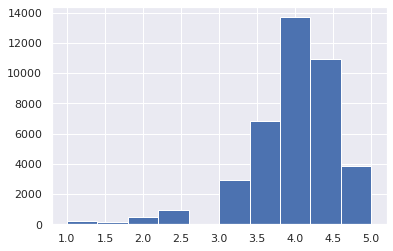

In [283]:
# Посмотрим ближе на наш таргет

df[df.train==1].Rating.hist()

plt.show()

По графику видна, что рейтинговая система оценивания пятибальная. Выбросов не наблюдается. Основная масса значений распределена между 3 и 5 баллами

## 2. City

In [284]:
col_info(df.City)

Количество пропусков: 0

count      50000
unique        31
top       London
freq        7193
Name: City, dtype: object

Распределение:
London        7193
Paris         6108
Madrid        3813
Barcelona     3395
Berlin        2705
Milan         2694
Rome          2589
Prague        1816
Lisbon        1647
Vienna        1443
Amsterdam     1372
Brussels      1314
Hamburg       1186
Munich        1145
Lyon          1126
Stockholm     1033
Budapest      1021
Warsaw         925
Dublin         836
Copenhagen     819
Athens         776
Edinburgh      745
Zurich         685
Oporto         642
Geneva         590
Krakow         554
Oslo           488
Helsinki       475
Bratislava     380
Luxembourg     263
Ljubljana      222
Name: City, dtype: int64



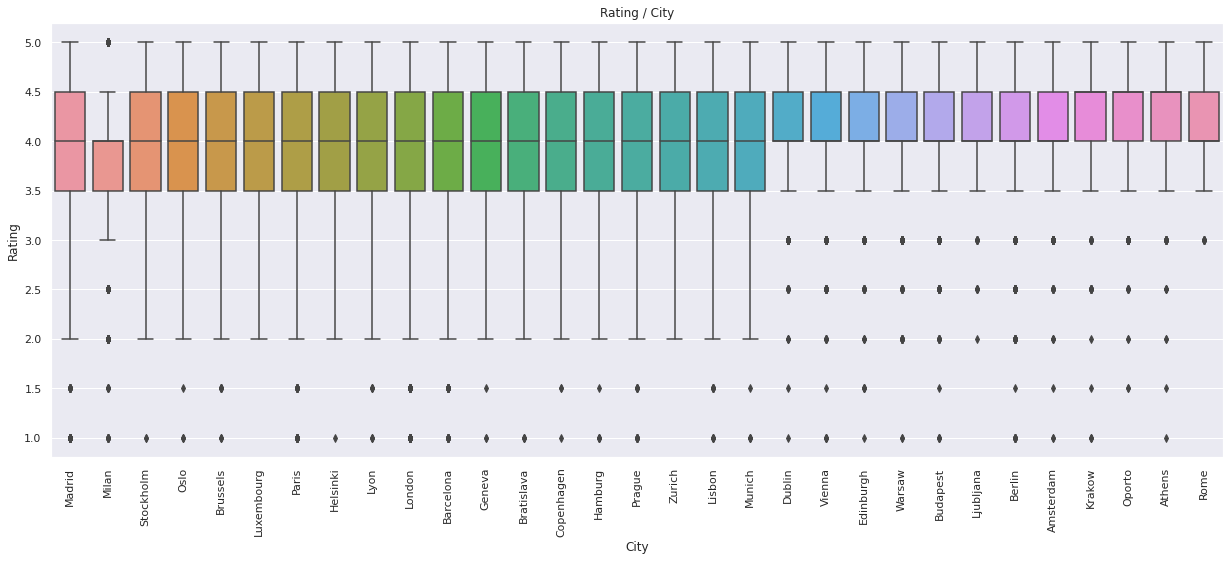

In [285]:
sns.set()
plt.figure(figsize=(21, 8))
order = df[df.train == 1].groupby('City').Rating.mean().sort_values().index

g = sns.boxplot(x = 'City', y = 'Rating', data = df[df.train == 1], order=order)
g.set_title('Rating / City')
g.set_ylabel('Rating')
g.set_xticklabels(g.get_xticklabels(), rotation = 90)

plt.show()

In [286]:
df[df.train == 1].groupby('City').Rating.mean().sort_values()

City
Madrid        3.800837
Milan         3.824895
Stockholm     3.870122
Oslo          3.893506
Brussels      3.908962
Luxembourg    3.914286
Paris         3.942414
Helsinki      3.946809
Lyon          3.948430
London        3.955098
Barcelona     3.961229
Geneva        3.962578
Bratislava    3.970100
Copenhagen    3.985584
Hamburg       4.021075
Prague        4.032571
Zurich        4.039963
Lisbon        4.046154
Munich        4.047032
Dublin        4.061664
Vienna        4.078045
Edinburgh     4.088087
Warsaw        4.089409
Budapest      4.090074
Ljubljana     4.112022
Berlin        4.124594
Amsterdam     4.131215
Krakow        4.146727
Oporto        4.178363
Athens        4.230096
Rome          4.230269
Name: Rating, dtype: float64

Самый высокий средний рейтинг ресторанов в Риме, а самый низкий в Мадриде. Интересно заметить, что сразу два итальянский города располагаются в разных краях списка, Рим топ 1 по среднему рейтингу и Милан боттом 2 

In [287]:
# Создадим признак принадлежности города к определенной стране, для этого создадим словарь, 
# где каждому городу будет соответствовать страна, в которой он находится

city_of_country = {
    'London': 'UK',
    'Paris': 'France',
    'Madrid': 'Spain',
    'Barcelona': 'Spain',
    'Berlin': 'Germany',
    'Milan': 'Italy',
    'Rome': 'Italy',
    'Prague': 'Czech Republic',
    'Lisbon': 'Portugal',
    'Vienna': 'Austria',
    'Amsterdam': 'Netherlands',
    'Brussels': 'Belgium',
    'Hamburg': 'Germany',
    'Munich': 'Germany',
    'Lyon': 'France',
    'Stockholm': 'Sweden',
    'Budapest': 'Hungary',
    'Warsaw': 'Poland',
    'Dublin': 'Ireland' ,
    'Copenhagen': 'Denmark',
    'Athens': 'Greece',
    'Edinburgh': 'Schotland',
    'Zurich': 'Switzerland',
    'Oporto': 'Portugal',
    'Geneva': 'Switzerland',
    'Krakow': 'Poland',
    'Oslo': 'Norway',
    'Helsinki': 'Finland',
    'Bratislava': 'Slovakia',
    'Luxembourg': 'Luxembourg',
    'Ljubljana': 'Slovenia'
}

df['Country'] = df['City'].map(city_of_country)

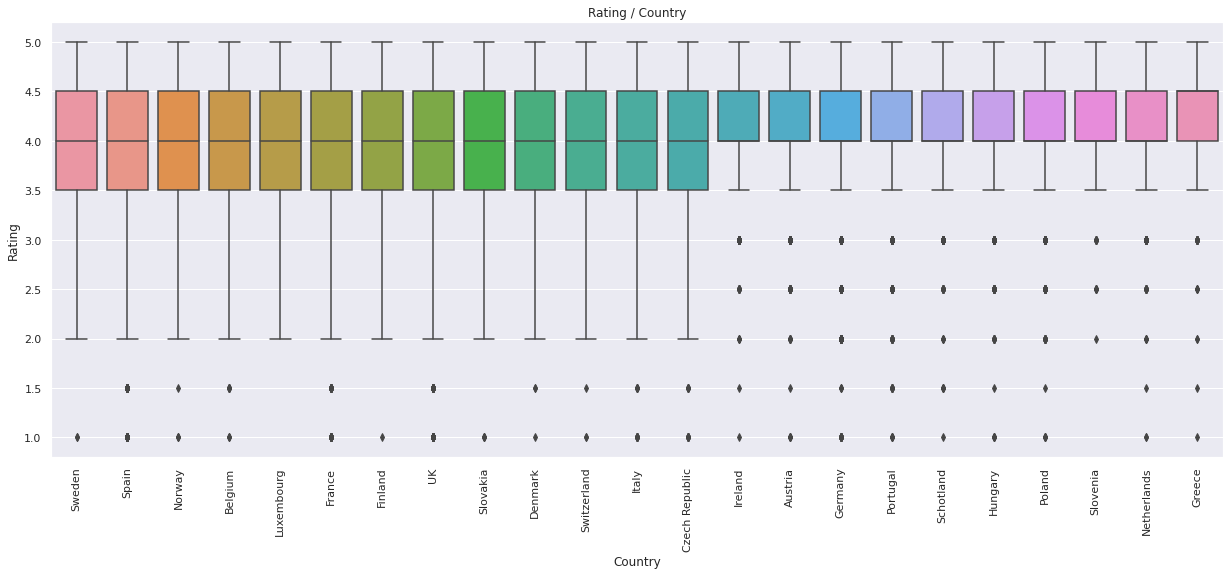

In [288]:
plt.figure(figsize=(21, 8))
order = df[df.train == 1].groupby('Country').Rating.mean().sort_values().index

g = sns.boxplot(x = 'Country', y = 'Rating', data = df[df.train == 1], order=order)
g.set_title('Rating / Country')
g.set_ylabel('Rating')
g.set_xticklabels(g.get_xticklabels(), rotation = 90)

plt.show()

In [289]:
df[df.train == 1].groupby('Country').Rating.mean().sort_values()

Country
Sweden            3.870122
Spain             3.875899
Norway            3.893506
Belgium           3.908962
Luxembourg        3.914286
France            3.943341
Finland           3.946809
UK                3.955098
Slovakia          3.970100
Denmark           3.985584
Switzerland       4.003435
Italy             4.024935
Czech Republic    4.032571
Ireland           4.061664
Austria           4.078045
Germany           4.082687
Portugal          4.083563
Schotland         4.088087
Hungary           4.090074
Poland            4.111111
Slovenia          4.112022
Netherlands       4.131215
Greece            4.230096
Name: Rating, dtype: float64

По странам ситуация иная, по среднему рейтингу ресторанов лидеры Греция, Нидерланды и Словения, замыкают же список Швеция и Испания

In [290]:
# Создадим признак, флаг указывающий на то, является ли город столицей страны

capitals = {
    'London': 1,
    'Paris': 1,
    'Madrid': 1,
    'Barcelona': 0,
    'Berlin': 1,
    'Milan': 0,
    'Rome': 1,
    'Prague': 1,
    'Lisbon': 1,
    'Vienna': 1,
    'Amsterdam': 1,
    'Brussels': 1,
    'Hamburg': 0,
    'Munich': 0,
    'Lyon': 0,
    'Stockholm': 1,
    'Budapest': 1,
    'Warsaw': 1,
    'Dublin': 1,
    'Copenhagen': 1,
    'Athens': 1,
    'Edinburgh': 1,
    'Zurich': 0,
    'Oporto': 0,
    'Geneva': 0,
    'Krakow': 0,
    'Oslo': 1,
    'Helsinki': 1,
    'Bratislava': 1,
    'Luxembourg': 1,
    'Ljubljana': 1
}

# df['Сapital'] = df['City'].map(capitals) Закоментирован так как работа модели с данным признаком ухудшается

In [291]:
## Признак - Население каждого из городов

# Создадим словарь, в котором укажем данные о количестве жителей городов (Google в помощь)
population = {
    'London': 7556900,
    'Paris': 2138551,
    'Madrid': 3255944,
    'Barcelona': 1621537,
    'Berlin': 3426354,
    'Milan': 1236837,
    'Rome': 2318895,
    'Prague': 1165581,
    'Lisbon': 517802,
    'Vienna': 1691468,
    'Amsterdam': 741636,
    'Brussels': 1019022,
    'Hamburg': 1739117,
    'Munich': 1260391,
    'Lyon': 472317,
    'Stockholm': 1515017,
    'Budapest': 1741041,
    'Warsaw': 1702139,
    'Dublin': 1024027,
    'Copenhagen': 1153615,
    'Athens': 664046,
    'Edinburgh': 464990,
    'Zurich': 341730,
    'Oporto': 249633,
    'Geneva': 183981,
    'Krakow': 755050,
    'Oslo': 580000,
    'Helsinki': 558457,
    'Bratislava': 423737,
    'Luxembourg': 76684,
    'Ljubljana': 272220
}

df['Population'] = df['City'].map(population)

In [292]:
# Создадим признак, количество ресторанов в городе

restaurants_count_dict = df.groupby('City').ID_TA.count().to_dict()
df['Restaurants_Count'] = df['City'].map(restaurants_count_dict)

In [293]:
# На основе признаков двух вышесозданных признаков создадим новый, который отношением количетсва ресторанов на тысячу человек в городе

df['Restaurants_per_1000'] = (df['Restaurants_Count'] / df['Population']) * 1000

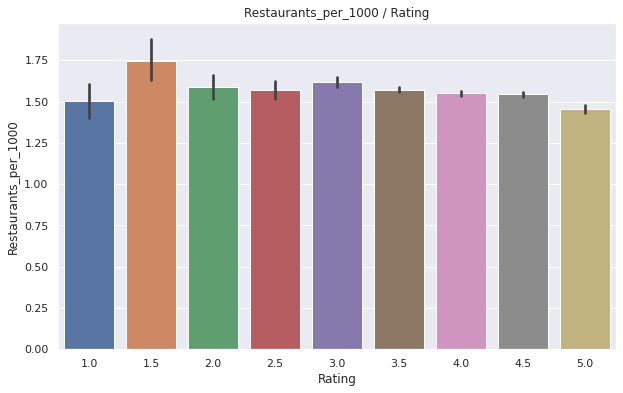

In [294]:
plt.figure(figsize=(10, 6))

g = sns.barplot(x = 'Rating', y = 'Restaurants_per_1000', data = df[df.train == 1])
g.set_title('Restaurants_per_1000 / Rating')
g.set_ylabel('Restaurants_per_1000')
plt.show()

In [295]:
# Внесем данные признаки в наши списки

cat_cols.append('City')
cat_cols.append('Country')
num_cols.append('Population')
num_cols.append('Restaurants_per_1000')
num_cols.append('Restaurants_Count')

## 3. Cuisine Style

In [296]:
col_info(df['Cuisine Style'])

Количество пропусков: 11590

count           38410
unique          10731
top       ['Italian']
freq             1332
Name: Cuisine Style, dtype: object

Распределение:
['Italian']                                                                                                                     1332
['French']                                                                                                                      1019
['Spanish']                                                                                                                      860
['French', 'European']                                                                                                           503
['Cafe']                                                                                                                         500
                                                                                                                                ... 
['Chinese', 'Japanese', 'Internati

In [297]:
# Для начала получим список всех кухонь

all_cuisine = []

for i in df['Cuisine Style'].dropna().str[2:-2].str.split("', '"):
    if i == np.nan:
        continue
    else:
        all_cuisine += i

# Посмотрим наиболее часто встречающиеся кухни

c = Counter()
for word in all_cuisine:
    c[word] += 1
c.most_common()

[('Vegetarian Friendly', 14021),
 ('European', 12561),
 ('Mediterranean', 7820),
 ('Italian', 7433),
 ('Vegan Options', 5684),
 ('Gluten Free Options', 5185),
 ('Bar', 4094),
 ('French', 3970),
 ('Asian', 3786),
 ('Pizza', 3502),
 ('Spanish', 3456),
 ('Pub', 3058),
 ('Cafe', 2883),
 ('Fast Food', 2122),
 ('British', 1992),
 ('International', 1966),
 ('Seafood', 1878),
 ('Japanese', 1860),
 ('Central European', 1727),
 ('American', 1642),
 ('Sushi', 1450),
 ('Chinese', 1446),
 ('Portuguese', 1385),
 ('Indian', 1328),
 ('Middle Eastern', 980),
 ('Thai', 923),
 ('Wine Bar', 877),
 ('German', 820),
 ('Halal', 773),
 ('Greek', 768),
 ('Healthy', 758),
 ('Fusion', 748),
 ('Czech', 745),
 ('Steakhouse', 729),
 ('Barbecue', 710),
 ('Contemporary', 652),
 ('Soups', 630),
 ('Eastern European', 629),
 ('Vietnamese', 622),
 ('Grill', 617),
 ('Gastropub', 608),
 ('Turkish', 574),
 ('Mexican', 572),
 ('South American', 490),
 ('Delicatessen', 473),
 ('Austrian', 462),
 ('Polish', 453),
 ('Scandinavi

In [298]:
## Создадим признак обозначающий количество кухонь в ресторане (пропуски заполним медианным значением)

# находим медиану не учитывая пропуски
cuisines = df['Cuisine Style'].str[2:-2].str.split("', '").dropna()
cuisines_1 = []
for i in cuisines:
    cuisines_1.append(len(i))
cuisines_median = np.median(cuisines_1)

# создаем признак

def quantity(x):
    if x == cuisines_median:
        return x
    else:
        return len(x)

df['Cuisine_Style_Quantity'] = df['Cuisine Style'].str[2:-2].str.split("', '").fillna(cuisines_median)
df['Cuisine_Style_Quantity'] = df['Cuisine_Style_Quantity'].apply(quantity).astype('int')

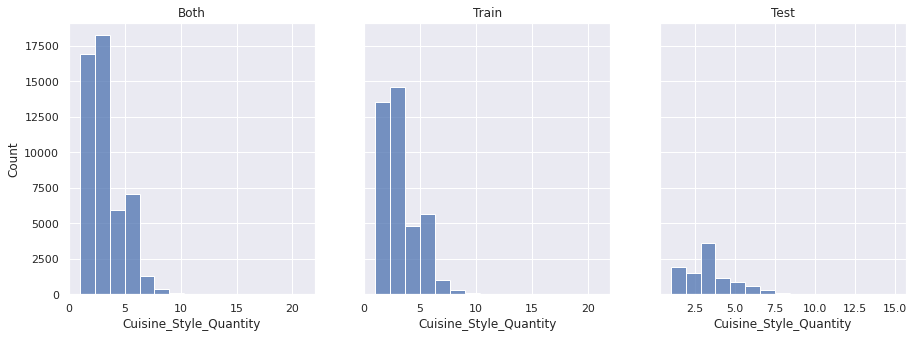

In [299]:
fig, ax = plt.subplots(1, 3, sharey=True)
fig.set_size_inches(15, 5)

_ = sns.histplot(df.Cuisine_Style_Quantity, ax=ax[0], bins=15)
_ = sns.histplot(df[df.train == 1].Cuisine_Style_Quantity, ax=ax[1], bins=15)
_ = sns.histplot(df[df.train == 0].Cuisine_Style_Quantity, ax=ax[2], bins=15)

ax[0].set_title('Both')
ax[1].set_title('Train')
ax[2].set_title('Test')

plt.show()

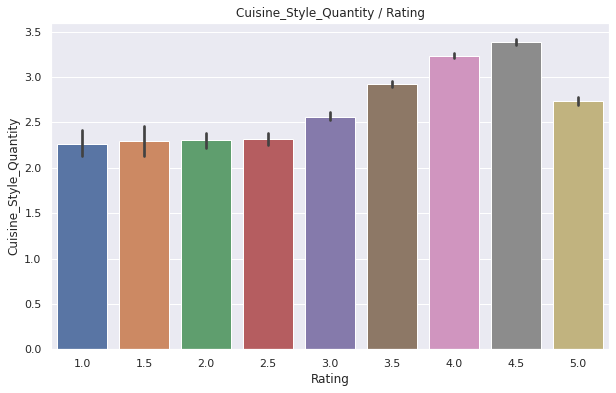

In [300]:
plt.figure(figsize=(10, 6))

g = sns.barplot(x = 'Rating', y = 'Cuisine_Style_Quantity', data = df[df.train == 1])
g.set_title('Cuisine_Style_Quantity / Rating')
g.set_ylabel('Cuisine_Style_Quantity')
plt.show()

In [301]:
df['Cuisine_Style_Quantity'].value_counts()

3     18228
1      9154
2      7794
4      5948
5      4482
6      2611
7      1294
8       363
9        93
10       26
11        4
21        1
15        1
13        1
Name: Cuisine_Style_Quantity, dtype: int64

In [302]:
# Заполним пропуски значением '__No_cuisine__'

df['Cuisine Style'].fillna('__No_cuisine__', inplace=True)
df['Cuisine Style'] = df['Cuisine Style'].str[2:-2].str.split("', '")

In [303]:
## Создадим признак в виде флага, есть ли в ресторане кухни из топ 3 по встречаемости

# Топ 3 кухни по частоте встречаемости
top_3_cuisines = list(map(operator.itemgetter(0), c.most_common(n=3)))

# Создаем признак
df['is_Top3_Cusine'] = df['Cuisine Style'].apply(lambda x: 1 if any(a in top_3_cuisines for a in x)==True else 0)

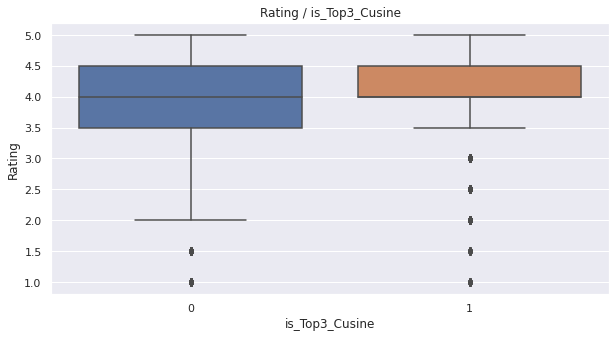

In [304]:
plt.figure(figsize=(10, 5))

g = sns.boxplot(x = 'is_Top3_Cusine', y = 'Rating', data = df[df.train == 1])
g.set_title('Rating / is_Top3_Cusine')
g.set_ylabel('Rating')
g.set_xticklabels(g.get_xticklabels())

plt.show()

In [305]:
df[df.train == 1].groupby('is_Top3_Cusine').Rating.median()

is_Top3_Cusine
0    4.0
1    4.0
Name: Rating, dtype: float64

In [306]:
df[df.train == 1].groupby('is_Top3_Cusine').Rating.mean()

is_Top3_Cusine
0    3.927833
1    4.070193
Name: Rating, dtype: float64

Как видно из графика, рестораны, в которых присутствуют 3 самых распространенных кухни, получают меньше низких оценок, но в то же время медианный рейтинг в обоих случаях одинаков

In [307]:
# Флаг обозначающий, большее ли в ресторане количество кухонь, чем медиана по всем ресторанам

df['Cuisines_more_than_median'] = df['Cuisine_Style_Quantity'].apply(lambda x: 1 if x > cuisines_median else 0)

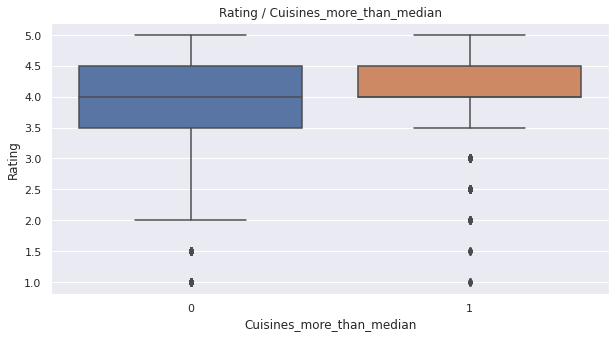

In [308]:
plt.figure(figsize=(10, 5))

g = sns.boxplot(x = 'Cuisines_more_than_median', y = 'Rating', data = df[df.train == 1])
g.set_title('Rating / Cuisines_more_than_median')
g.set_ylabel('Rating')
g.set_xticklabels(g.get_xticklabels())

plt.show()

In [309]:
df['Cuisines_more_than_median'].value_counts()

0    35176
1    14824
Name: Cuisines_more_than_median, dtype: int64

In [310]:
# Создадим dummy для наших кухонь

cuisines_dummy = df['Cuisine Style'].apply(lambda x: pd.Series([1] * len(x), index=x)).fillna(0, downcast='infer')

# Попробуем взять все значения и топ 50 значений после чего сравним работу модели

cuisines_dummy_50 = cuisines_dummy[list(map(operator.itemgetter(0), c.most_common(n=50)))]

# Создадим список остальных значений не вошедих в топ 50 (включая значение No_cuisine)
except_top_50 = list(map(operator.itemgetter(0), c.most_common()[50:]))
except_top_50.append('No_cuisine')

# Создадим в дамми из топ 50 значений признак обозначающий остальные значения, не вошедшие в топ 50
cuisines_dummy_50['Other'] = cuisines_dummy.copy().loc[:, except_top_50].any(axis=1).astype('int')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [311]:
display(cuisines_dummy.head(2))
cuisines_dummy_50.head(2)

,European,French,International,No_cuisine,Japanese,Sushi,Asian,Grill,Vegetarian Friendly,Vegan Options,Gluten Free Options,German,Central European,Italian,Pizza,Fast Food,Mediterranean,Spanish,Healthy,Cafe,Thai,Vietnamese,Bar,Pub,Chinese,British,Polish,Fusion,Dutch,Mexican,Venezuelan,South American,Soups,Belgian,Steakhouse,Latin,Barbecue,Argentinean,Irish,Seafood,...,Scottish,Arabic,Ukrainian,Chilean,Mongolian,Cuban,Persian,Indonesian,Colombian,Jamaican,Norwegian,Hawaiian,Armenian,Taiwanese,Bangladeshi,Sri Lankan,Cambodian,Albanian,New Zealand,Croatian,Central Asian,Filipino,Tunisian,Cajun & Creole,Romanian,Georgian,Polynesian,Azerbaijani,Caucasian,Afghani,Uzbek,Salvadoran,Yunnan,Native American,Canadian,Xinjiang,Burmese,Fujian,Welsh,Latvian
0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


,Vegetarian Friendly,European,Mediterranean,Italian,Vegan Options,Gluten Free Options,Bar,French,Asian,Pizza,Spanish,Pub,Cafe,Fast Food,British,International,Seafood,Japanese,Central European,American,Sushi,Chinese,Portuguese,Indian,Middle Eastern,Thai,Wine Bar,German,Halal,Greek,Healthy,Fusion,Czech,Steakhouse,Barbecue,Contemporary,Soups,Eastern European,Vietnamese,Grill,Gastropub,Turkish,Mexican,South American,Delicatessen,Austrian,Polish,Scandinavian,Hungarian,Lebanese,Other
0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [312]:
# Создадим признак, обозначающий количество ресторанов в каждом городе

cusines_in_city={}
cusines_count_in_city={}
for city_name, group in df.groupby('City'):
    cusines_list  = list(itertools.chain.from_iterable(group['Cuisine Style']))
    cusines_in_city[city_name] = Counter(cusines_list)
for city_name in cusines_in_city.keys():
    cusines_count_in_city[city_name] = len(cusines_in_city[city_name])
    
df['CuisinesCount_in_City'] = df['City'].map(cusines_count_in_city)

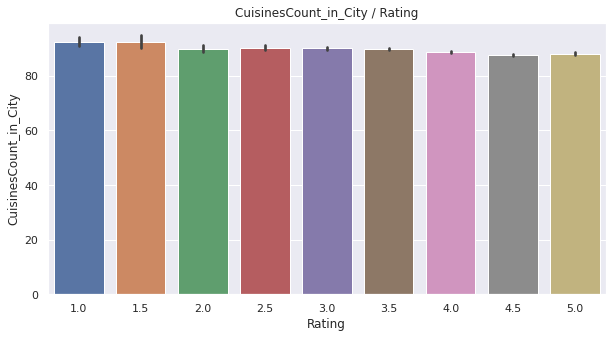

In [313]:
plt.figure(figsize=(10, 5))

g = sns.barplot(x = 'Rating', y = 'CuisinesCount_in_City', data = df[df.train == 1])
g.set_title('CuisinesCount_in_City / Rating')
g.set_ylabel('CuisinesCount_in_City')
plt.show()

Интересно, что в городах с более разнообразным меню больше отрицательных оценок. Возможно на это влияет непредрасположенность людей к определенным экзотическим кухням и к ценам на блюда к ним, или же так влияет более высокая конкуренция, т.к. вероятнее всего, там где более разнообразная кухня больше ресторанов в общем.

In [314]:
# Создадим признак, обозначающий отношения количества кухонь в ресторане на количество кухонь в городе

df['Weighted_Cuisines_Count'] = df.Cuisine_Style_Quantity / df.CuisinesCount_in_City

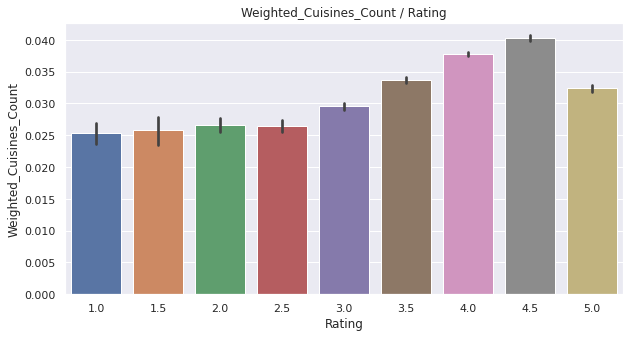

In [315]:
plt.figure(figsize=(10, 5))

g = sns.barplot(x = 'Rating', y = 'Weighted_Cuisines_Count', data = df[df.train == 1])
g.set_title('Weighted_Cuisines_Count / Rating')
g.set_ylabel('Weighted_Cuisines_Count')
plt.show()

По графику можно отдаленно судить о том, что чем больше взвешенное количество кухонь у ресторана, тем лучший рейтинг у ресторана. Возможно это обуславливается отсутствием разнообразия в городах, ввиду малого количества видов кухонь в общем, из-за чего рестораны специализируищееся на более разнообразном меню больше нравятся посетителям.

In [316]:
# Создадим признак, количество ресторанов на один стиль кухни в городе

df['Restaurants_per_Cuisine'] = df.Restaurants_Count / df.CuisinesCount_in_City

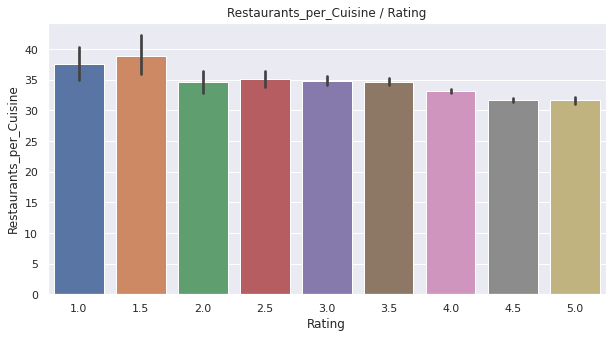

In [317]:
plt.figure(figsize=(10, 5))

g = sns.barplot(x = 'Rating', y = 'Restaurants_per_Cuisine', data = df[df.train == 1])
g.set_title('Restaurants_per_Cuisine / Rating')
g.set_ylabel('Restaurants_per_Cuisine')
plt.show()

Из графика видно, для высоких оценок характерно меньшее среднее значение признака.

In [318]:
# Проверим наш датасет

df.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,train,Number_of_Reviews_NAN,Cuisine_Style_NAN,Price_Range_NAN,Country,Population,Restaurants_Count,Restaurants_per_1000,Cuisine_Style_Quantity,is_Top3_Cusine,Cuisines_more_than_median,CuisinesCount_in_City,Weighted_Cuisines_Count,Restaurants_per_Cuisine
41194,id_1194,Berlin,[Vegetarian Friendly],1250.0,0.0,$$ - $$$,29.0,"[['A Quiet Achiever', 'Simple amazing'], ['08/...",/Restaurant_Review-g187323-d7389608-Reviews-La...,d7389608,0,0.0,0.0,0.0,Germany,3426354,2705,0.789469,1,1,0,99,0.010101,27.323232
22615,id_7727,Madrid,[Spanish],7734.0,3.0,NaN,19.0,"[[], []]",/Restaurant_Review-g187514-d10374076-Reviews-P...,d10374076,1,0.0,0.0,1.0,Spain,3255944,3813,1.171089,1,0,0,94,0.010638,40.563830
22031,id_1320,Vienna,"[Austrian, Central European, European]",1321.0,4.0,$$ - $$$,29.0,"[['Great bar', 'Cool spot for coctails'], ['09...",/Restaurant_Review-g190454-d7653478-Reviews-If...,d7653478,1,0.0,0.0,0.0,Austria,1691468,1443,0.853105,3,1,0,90,0.033333,16.033333
41251,id_1251,Berlin,"[Italian, Pizza, Fast Food, Mediterranean, Tur...",3363.0,0.0,$,NaN,"[[], []]",/Restaurant_Review-g187323-d13150803-Reviews-M...,d13150803,0,1.0,0.0,0.0,Germany,3426354,2705,0.789469,5,1,1,99,0.050505,27.323232
48189,id_8189,Milan,"[Italian, Seafood, Mediterranean, Gluten Free ...",581.0,0.0,$$ - $$$,509.0,"[['Nice seefood place', 'Enjoyable good meal']...",/Restaurant_Review-g187849-d3135018-Reviews-Pe...,d3135018,0,0.0,0.0,0.0,Italy,1236837,2694,2.178137,4,1,1,84,0.047619,32.071429


In [319]:
# Внесем данные признаки в наши списки

num_cols.append('Cuisine_Style_Quantity')
bin_cols.append('is_Top3_Cusine')
bin_cols.append('Cuisines_more_than_median')
num_cols.append('CuisinesCount_in_City')
num_cols.append('Weighted_Cuisines_Count')
num_cols.append('Restaurants_per_Cuisine')

## 4. Ranking

In [320]:
col_info(df.Ranking)

Количество пропусков: 0

count    50000.000000
mean      3664.427520
std       3700.092452
min          1.000000
25%        972.000000
50%       2278.000000
75%       5241.000000
max      16444.000000
Name: Ranking, dtype: float64

Распределение:
93.0       22
491.0      21
72.0       21
842.0      21
106.0      20
           ..
13317.0     1
8337.0      1
12170.0     1
11972.0     1
11783.0     1
Name: Ranking, Length: 12975, dtype: int64



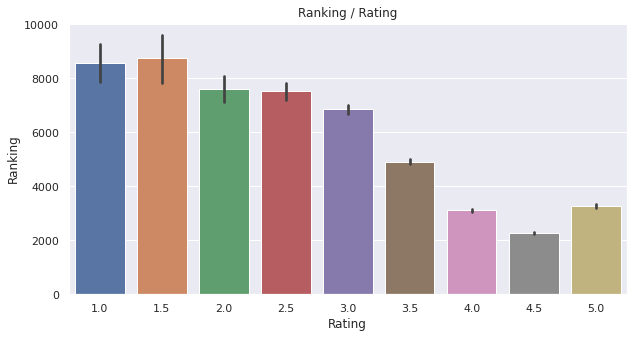

In [321]:
plt.figure(figsize=(10, 5))

g = sns.barplot(x = 'Rating', y = 'Ranking', data = df[df.train == 1])
g.set_title('Ranking / Rating')
g.set_ylabel('Ranking')
plt.show()

In [322]:
# Создадим признак показывающий нам взвешенный ранк ресторана (отношение ранка к общему числу ресторанов в городе представленных в датасете)

df['Weighted_Ranking'] = df.Ranking / df.Restaurants_Count

In [323]:
df['Weighted_Ranking']

0        0.911919
1        1.487899
2        0.049075
3        1.278373
4        0.542358
           ...   
49995    0.607118
49996    1.585914
49997    2.064588
49998    1.488493
49999    1.111821
Name: Weighted_Ranking, Length: 50000, dtype: float64

Очевидно что в датасете представлены не все рестораны каждого из городов, поэтому взвешенный ранк в некоторых случаях превышает единицу

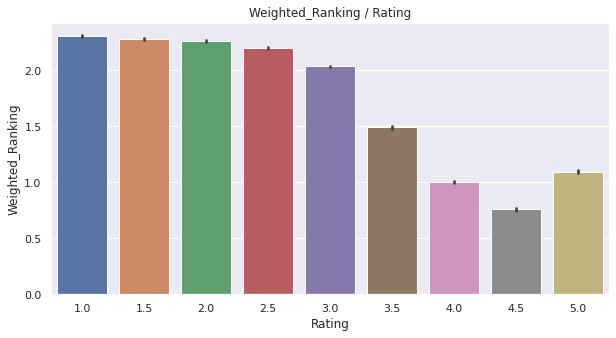

In [324]:
plt.figure(figsize=(10, 5))

g = sns.barplot(x = 'Rating', y = 'Weighted_Ranking', data = df[df.train == 1])
g.set_title('Weighted_Ranking / Rating')
g.set_ylabel('Weighted_Ranking')
plt.show()

По графику видно, что среднее значение взвешенного ранга падает с увеличением рейтинга и только лишь на рейтинге 5 оно возрастает (причиной чему возможно является недостаток данных в датасете)

In [325]:
num_cols.append('Ranking')
num_cols.append('Weighted_Ranking')

## 5. Price Range

In [326]:
col_info(df['Price Range'])

Количество пропусков: 17361

count        32639
unique           3
top       $$ - $$$
freq         23041
Name: Price Range, dtype: object

Распределение:
$$ - $$$    23041
$            7816
$$$$         1782
Name: Price Range, dtype: int64



In [327]:
## Заполним признаки наиболее частым значением '$$ - $$$' и заменим все строковые значения на цифры, чтобы получить категориальный порядковый признак

# Смотрим какие уникальные данные по ценам присутствуют в датасете

df['Price Range'].unique()

# Заполняем пропуски самым частым значением

df['Price Range'] = df['Price Range'].fillna(df['Price Range'].value_counts().index[0])

# Преобразуем признак при помощи OrdinalEncoder

oenc = OrdinalEncoder(categories = [['$', '$$ - $$$', '$$$$']])

df['Price Range'] = oenc.fit_transform(df[['Price Range']]).astype('int')

In [328]:
oenc.categories_

[array(['$', '$$ - $$$', '$$$$'], dtype=object)]

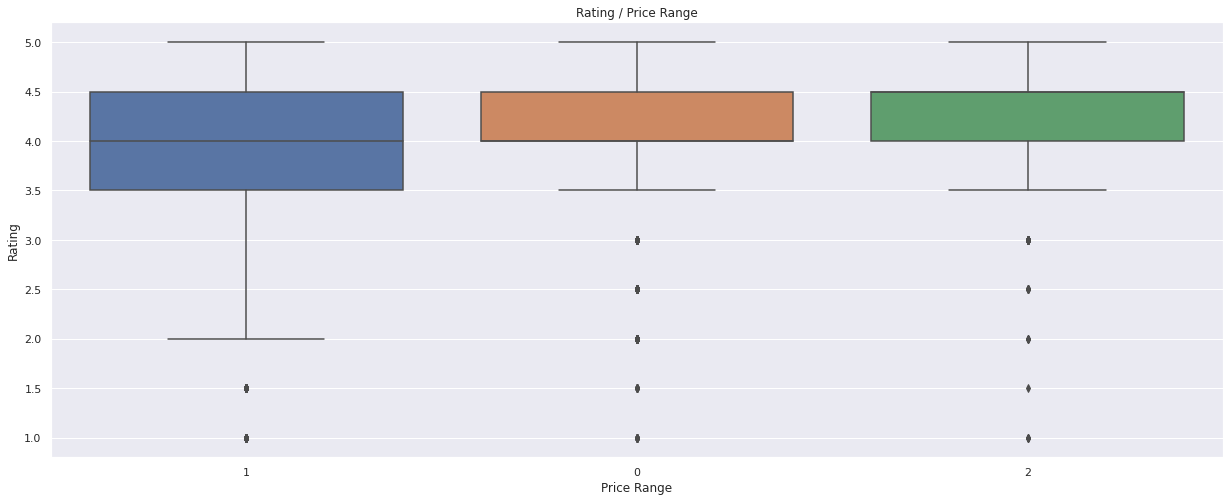

In [329]:
plt.figure(figsize=(21, 8))
order = df[df.train == 1].groupby('Price Range').Rating.mean().sort_values().index

g = sns.boxplot(x = 'Price Range', y = 'Rating', data = df[df.train == 1], order=order)
g.set_title('Rating / Price Range')
g.set_ylabel('Rating')
g.set_xticklabels(g.get_xticklabels())

plt.show()

In [330]:
ordinal_cat_cols.append('Price Range')

## 6. Number of Reviews

In [331]:
col_info(df['Number of Reviews'])

Количество пропусков: 3200

count    46800.000000
mean       124.471197
std        294.114345
min          2.000000
25%          9.000000
50%         33.000000
75%        115.000000
max       9660.000000
Name: Number of Reviews, dtype: float64

Распределение:
2.0       2403
3.0       2042
4.0       1707
5.0       1471
6.0       1258
          ... 
4080.0       1
972.0        1
2036.0       1
1201.0       1
1543.0       1
Name: Number of Reviews, Length: 1573, dtype: int64



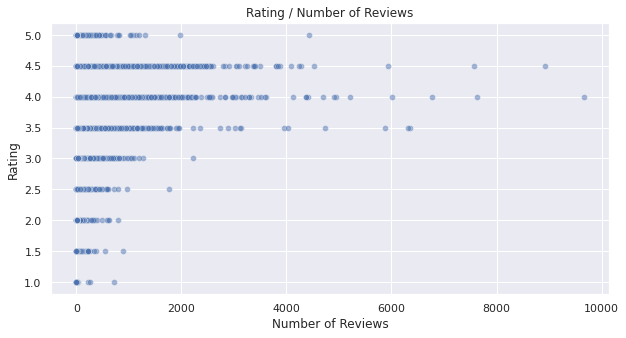

In [332]:
plt.figure(figsize=(10, 5))

g = sns.scatterplot(x = 'Number of Reviews', y = 'Rating', data = df[df.train == 1], alpha=0.5)
g.set_title('Rating / Number of Reviews')
g.set_ylabel('Rating')
plt.show()

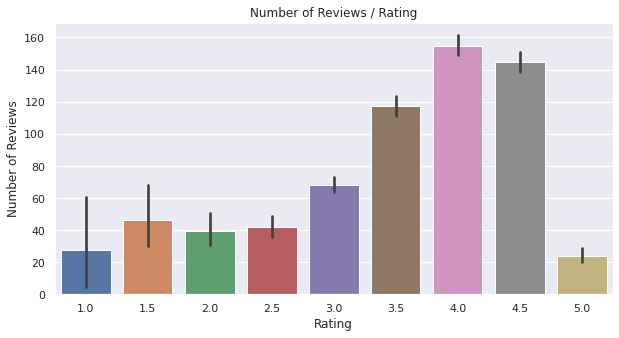

In [333]:
plt.figure(figsize=(10, 5))

g = sns.barplot(x = 'Rating', y = 'Number of Reviews', data = df[df.train == 1])
g.set_title('Number of Reviews / Rating')
g.set_ylabel('Number of Reviews')
plt.show()

На графикам выше видно, у ресторанов с оценками от 3 до 4 растет среднее количество отзывов, чуть снижается на ресторанах с рейтингом 4.5 и падает на самом высоком рейтинге.

In [334]:
# Заполним пропуски медианным значением

df['Number of Reviews'].fillna(df['Number of Reviews'].median(), inplace=True)

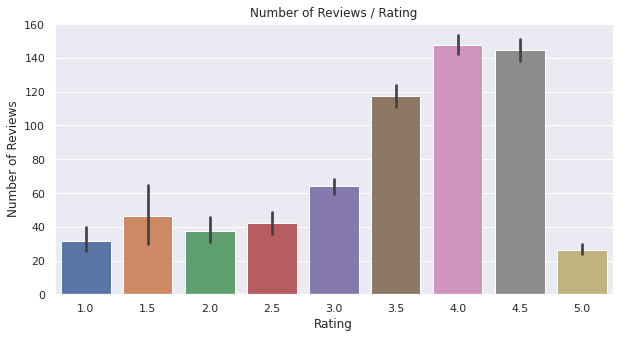

In [335]:
plt.figure(figsize=(10, 5))

g = sns.barplot(x = 'Rating', y = 'Number of Reviews', data = df[df.train == 1])
g.set_title('Number of Reviews / Rating')
g.set_ylabel('Number of Reviews')
plt.show()

In [336]:
df['Number of Reviews'].isna().sum()

0

In [337]:
num_cols.append('Number of Reviews')

## 7. Reviews

In [338]:
col_info(df.Reviews)

Количество пропусков: 2

count        49998
unique       41857
top       [[], []]
freq          8112
Name: Reviews, dtype: object

Распределение:
[[], []]                                                                                                         8112
[['Good Paella', 'Good enough. Nothing more'], ['09/20/2017', '05/29/2017']]                                        2
[['Great food, service and atmosphere', 'Decor and food'], ['11/06/2017', '10/22/2017']]                            2
[['Very average food. Over average prices.', 'great food with great service!'], ['11/17/2017', '08/17/2017']]       2
[['Delicious'], ['06/06/2017']]                                                                                     2
                                                                                                                 ... 
[['Horrible experience!'], ['03/27/2017']]                                                                          1
[['NON.', 'Tandoori Montparn

In [339]:
# Посмотрим на пропуски

df[df.Reviews.isna()]

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,train,Number_of_Reviews_NAN,Cuisine_Style_NAN,Price_Range_NAN,Country,Population,Restaurants_Count,Restaurants_per_1000,Cuisine_Style_Quantity,is_Top3_Cusine,Cuisines_more_than_median,CuisinesCount_in_City,Weighted_Cuisines_Count,Restaurants_per_Cuisine,Weighted_Ranking
48168,id_8168,Lisbon,[No_cuisine],3389.0,0.0,1,2.0,NaN,/Restaurant_Review-g189158-d12683988-Reviews-O...,d12683988,0,0.0,1.0,1.0,Portugal,517802,1647,3.180752,3,0,0,74,0.040541,22.256757,2.057681
49608,id_9608,Vienna,[No_cuisine],1779.0,0.0,1,33.0,NaN,/Restaurant_Review-g190454-d12605368-Reviews-R...,d12605368,0,1.0,1.0,1.0,Austria,1691468,1443,0.853105,3,0,0,90,0.033333,16.033333,1.232848


In [340]:
# Заполними пропуски

df['Reviews'].fillna("[[], []]", inplace=True)

In [341]:
# Посмотрим на отдельное значение 

df['Reviews'][0]

"[['Good food at your doorstep', 'A good hotel restaurant'], ['12/31/2017', '11/20/2017']]"

In [342]:
# Предобработаем значения, изменив тип данных со строки на список списков при помощи функции 

def make_list(list_string):
    list_string = list_string.replace('nan]', "'Nan']")
    list_string = list_string.replace('[nan', "['Nan'")
    result_list = ast.literal_eval(list_string)
    return result_list

df['Reviews'] = df['Reviews'].apply(make_list)

In [343]:
# Создадим признак обозначающий количество дней между двумя последними отзывами

def delta_date(date):
    if len(date[1]) == 0 or len(date[1]) == 1:
        return 0
    
    elif len(date[1]) == 2:
        date1 = datetime.strptime(date[1][0],'%m/%d/%Y')
        date2 = datetime.strptime(date[1][1],'%m/%d/%Y')
        return abs(date1 - date2).days

df['Days_between_reviews'] = df['Reviews'].apply(delta_date)

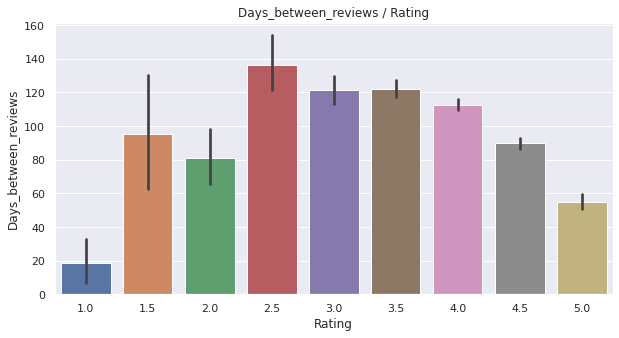

In [344]:
plt.figure(figsize=(10, 5))

g = sns.barplot(x = 'Rating', y = 'Days_between_reviews', data = df[df.train == 1])
g.set_title('Days_between_reviews / Rating')
g.set_ylabel('Days_between_reviews')
plt.show()

На графике видно, что начиная с рейтинга 2.5 и по 5 средняя дельта между двумя последними отзывами начинает падать

In [345]:
## Признак - Количество дней с последнего отзыва
## Обоснованием может являтся то, что рейтиг напрямую зависит от того, насколько "свежий" последний отзыв (информация взята с https://www.tripadvisor.ru/ForRestaurants/r3998)

# Определим количество дней с последнего отзыва

Current_Date_dt = datetime.strptime(Current_Date,'%m/%d/%Y')

def days_since_last_review(row):
    if len(row[1]) == 0:
        date = datetime.strptime('02/01/2000','%m/%d/%Y') # Дата основания сайта
    
    elif len(row[1]) == 1:
        date = datetime.strptime(row[1][0],'%m/%d/%Y')
    
    else:
        date1 = datetime.strptime(row[1][0],'%m/%d/%Y')
        date2 = datetime.strptime(row[1][1],'%m/%d/%Y')
        date = max(date1, date2)
    
    return (Current_Date_dt - date).days

df['Days_Since_Last_Review'] = df['Reviews'].apply(days_since_last_review)

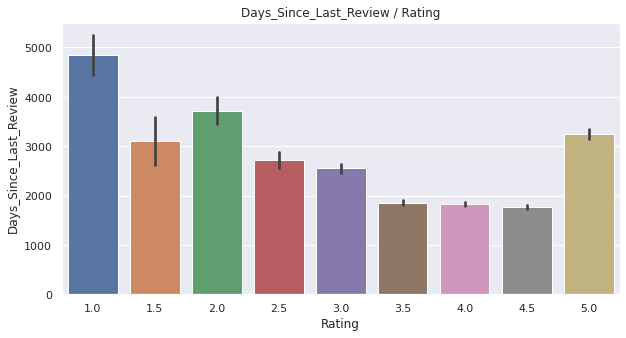

In [346]:
plt.figure(figsize=(10, 5))

g = sns.barplot(x = 'Rating', y = 'Days_Since_Last_Review', data = df[df.train == 1])
g.set_title('Days_Since_Last_Review / Rating')
g.set_ylabel('Days_Since_Last_Review')
plt.show()

In [347]:
df['Reviews'][0]

[['Good food at your doorstep', 'A good hotel restaurant'],
 ['12/31/2017', '11/20/2017']]

### Обработка текста

In [348]:
def review(reviews):
    string = ' '.join(reviews[0])
    return string

df['Text_Reviews'] = df['Reviews'].apply(review)

In [349]:
data = df['Text_Reviews']

# Переведем текст в нижний регистр

data = data.str.lower()

In [350]:
data

0        good food at your doorstep a good hotel restau...
1                   unique cuisine delicious nepalese food
2                    catch up with friends not exceptional
3                                                         
4        best place to try a bavarian food nice buildin...
                               ...                        
49995    by far best chicken burgers and wings in l... ...
49996                                       ok indian food
49997                                                     
49998                                                     
49999                   ethiopian dining in pleasant space
Name: Text_Reviews, Length: 50000, dtype: object

In [351]:
# Очистим данные от любых символов "не слов" при помощи функции

def clean_symbs(data):
    clean = re.sub(r"[^\w]", " ", data)
    return clean

data = data.apply(clean_symbs)

In [352]:
data

0        good food at your doorstep a good hotel restau...
1                   unique cuisine delicious nepalese food
2                    catch up with friends not exceptional
3                                                         
4        best place to try a bavarian food nice buildin...
                               ...                        
49995    by far best chicken burgers and wings in l    ...
49996                                       ok indian food
49997                                                     
49998                                                     
49999                   ethiopian dining in pleasant space
Name: Text_Reviews, Length: 50000, dtype: object

In [353]:
# Удалим все лишние пробелы

def without_space(data):
    a = re.sub(r'\s+', ' ', data)
    return a

data = data.apply(without_space)

In [354]:
# Удалим пробелы в начале и в конце строки

data = data.str.strip(' ')

In [355]:
# Создаем лист стоп слов

english_stopwords = stopwords.words("english")

In [356]:
# Лемматизируем наш текст, после чего избавимся от стоп-слов и разделим его на токены

mystem = Mystem() 

def preprocess_text(text):
    tokens = mystem.lemmatize(text)
    tokens = [token for token in tokens if token not in english_stopwords\
              and token != " "\
              and token.strip() not in punctuation]
    return tokens

In [357]:
!wget http://download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz
!tar -xvf mystem-3.0-linux3.1-64bit.tar.gz
!cp mystem /root/.local/bin/mystem

--2021-05-12 13:32:39--  http://download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz
Resolving download.cdn.yandex.net (download.cdn.yandex.net)... 5.45.205.241, 5.45.205.242, 5.45.205.245, ...
Connecting to download.cdn.yandex.net (download.cdn.yandex.net)|5.45.205.241|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: http://cache-mskm905.cdn.yandex.net/download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz [following]
--2021-05-12 13:32:39--  http://cache-mskm905.cdn.yandex.net/download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz
Resolving cache-mskm905.cdn.yandex.net (cache-mskm905.cdn.yandex.net)... 5.45.220.15, 2a02:6b8:0:2002::16
Connecting to cache-mskm905.cdn.yandex.net (cache-mskm905.cdn.yandex.net)|5.45.220.15|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16457938 (16M) [application/octet-stream]
Saving to: ‘mystem-3.0-linux3.1-64bit.tar.gz.2’

mystem-3.0-linux3.1 100%[===================>] 

In [358]:
data = data.apply(preprocess_text)

In [359]:
data

0          [good, food, doorstep, good, hotel, restaurant]
1             [unique, cuisine, delicious, nepalese, food]
2                            [catch, friends, exceptional]
3                                                       []
4        [best, place, try, bavarian, food, nice, build...
                               ...                        
49995    [far, best, chicken, burgers, wings, l, really...
49996                                   [ok, indian, food]
49997                                                   []
49998                                                   []
49999                 [ethiopian, dining, pleasant, space]
Name: Text_Reviews, Length: 50000, dtype: object

In [360]:
counter = Counter()
def count_words(sentence):
    global counter
    for x in sentence:
        counter[x] += 1
        
data.apply(count_words)

0        None
1        None
2        None
3        None
4        None
         ... 
49995    None
49996    None
49997    None
49998    None
49999    None
Name: Text_Reviews, Length: 50000, dtype: object

In [361]:
counter.most_common(n=500)

[('food', 13167),
 ('good', 11780),
 ('great', 10628),
 ('nice', 5702),
 ('place', 5166),
 ('service', 4383),
 ('restaurant', 3632),
 ('best', 3411),
 ('excellent', 3261),
 ('lunch', 2694),
 ('delicious', 2164),
 ('friendly', 1917),
 ('pizza', 1787),
 ('lovely', 1782),
 ('amazing', 1771),
 ('tasty', 1681),
 ('dinner', 1584),
 ('italian', 1378),
 ('little', 1300),
 ('bar', 1297),
 ('atmosphere', 1284),
 ('staff', 1233),
 ('meal', 1171),
 ('breakfast', 1127),
 ('experience', 1110),
 ('local', 1068),
 ('value', 1058),
 ('coffee', 980),
 ('fantastic', 967),
 ('authentic', 946),
 ('average', 934),
 ('quick', 904),
 ('quality', 903),
 ('price', 883),
 ('perfect', 882),
 ('cafe', 831),
 ('wonderful', 815),
 ('pub', 808),
 ('cheap', 798),
 ('sushi', 792),
 ('ok', 766),
 ('gem', 749),
 ('really', 743),
 ('bad', 718),
 ('fresh', 703),
 ('location', 689),
 ('beer', 686),
 ('go', 667),
 ('find', 661),
 ('visit', 645),
 ('one', 643),
 ('spot', 642),
 ('ever', 641),
 ('decent', 615),
 ('eat', 609),


In [362]:
df['Text_Reviews'] = data

In [363]:
df

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,train,Number_of_Reviews_NAN,Cuisine_Style_NAN,Price_Range_NAN,Country,Population,Restaurants_Count,Restaurants_per_1000,Cuisine_Style_Quantity,is_Top3_Cusine,Cuisines_more_than_median,CuisinesCount_in_City,Weighted_Cuisines_Count,Restaurants_per_Cuisine,Weighted_Ranking,Days_between_reviews,Days_Since_Last_Review,Text_Reviews
0,id_5569,Paris,"[European, French, International]",5570.0,3.5,1,194.0,"[[Good food at your doorstep, A good hotel res...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643,1,0.0,0.0,0.0,France,2138551,6108,2.856140,3,1,0,103,0.029126,59.300971,0.911919,41,815,"[good, food, doorstep, good, hotel, restaurant]"
1,id_1535,Stockholm,[No_cuisine],1537.0,4.0,1,10.0,"[[Unique cuisine, Delicious Nepalese food], [0...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032,1,0.0,1.0,1.0,Sweden,1515017,1033,0.681841,3,0,0,78,0.038462,13.243590,1.487899,382,993,"[unique, cuisine, delicious, nepalese, food]"
2,id_352,London,"[Japanese, Sushi, Asian, Grill, Vegetarian Fri...",353.0,4.5,2,688.0,"[[Catch up with friends, Not exceptional], [01...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781,1,0.0,0.0,0.0,UK,7556900,7193,0.951845,7,1,1,111,0.063063,64.801802,0.049075,2,807,"[catch, friends, exceptional]"
3,id_3456,Berlin,[No_cuisine],3458.0,5.0,1,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776,1,0.0,1.0,1.0,Germany,3426354,2705,0.789469,3,0,0,99,0.030303,27.323232,1.278373,0,7358,[]
4,id_615,Munich,"[German, Central European, Vegetarian Friendly]",621.0,4.0,1,84.0,"[[Best place to try a Bavarian food, Nice buil...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963,1,0.0,0.0,0.0,Germany,1260391,1145,0.908448,3,1,0,78,0.038462,14.679487,0.542358,272,858,"[best, place, try, bavarian, food, nice, build..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,id_9995,London,"[Caribbean, Barbecue, Jamaican, Vegetarian Fri...",4367.0,0.0,0,28.0,[[By far best Chicken burgers and wings in L.....,/Restaurant_Review-g186338-d11916827-Reviews-C...,d11916827,0,0.0,0.0,0.0,UK,7556900,7193,0.951845,4,1,1,111,0.036036,64.801802,0.607118,122,832,"[far, best, chicken, burgers, wings, l, really..."
49996,id_9996,Lisbon,"[Indian, Asian, Nepali, Bangladeshi]",2612.0,0.0,1,2.0,"[[Ok indian food], [11/25/2017]]",/Restaurant_Review-g189158-d12701633-Reviews-C...,d12701633,0,0.0,0.0,0.0,Portugal,517802,1647,3.180752,4,0,1,74,0.054054,22.256757,1.585914,0,851,"[ok, indian, food]"
49997,id_9997,Milan,[No_cuisine],5562.0,0.0,1,2.0,"[[], []]",/Restaurant_Review-g187849-d13198194-Reviews-Q...,d13198194,0,0.0,1.0,1.0,Italy,1236837,2694,2.178137,3,0,0,84,0.035714,32.071429,2.064588,0,7358,[]
49998,id_9998,Milan,[Italian],4010.0,0.0,1,2.0,"[[], []]",/Restaurant_Review-g187849-d3862815-Reviews-La...,d3862815,0,0.0,0.0,1.0,Italy,1236837,2694,2.178137,1,0,0,84,0.011905,32.071429,1.488493,0,7358,[]


In [364]:
## Создадим новые признаки при помощи модуля SentimentIntensityAnalyzer библиотеки nltk

# Переведем наши списки в текст
text_raw_str = df['Text_Reviews'].apply(lambda x: ' '.join(x))

# Применим модуль sia после чего получим Series состоящий из словарей с ключами neg, neutral, pos и compound
sia = SentimentIntensityAnalyzer()
Sentiment_dicts = text_raw_str.apply(lambda x: sia.polarity_scores(x))

# Создадим новый датафрейм где признаками будут ключи словарей

sentiments_df = pd.DataFrame(Sentiment_dicts.values.tolist())

In [365]:
sentiments_df.head(5)

,neg,neu,pos,compound
0,0.0,0.408,0.592,0.7003
1,0.0,0.519,0.481,0.5719
2,0.0,0.392,0.608,0.4767
3,0.0,0.000,0.000,0.0000
4,0.0,0.392,0.608,0.8519


In [366]:
# Соединим данный датасет с основным

df = pd.concat([df, sentiments_df], axis=1)

In [367]:
# Добавим так же новые признаки для количества слов, символов и средней длины слова
# Количество слов в строке
df['word_count'] = df.Text_Reviews.apply(lambda x: len(x))

# Количество символов в строке
df['char_count'] = df.Text_Reviews.apply(lambda x: sum(len(word) for word in x))

# Средняя длина слова в строке
df['avg_word_length'] = df['char_count'] / df['word_count']
df.avg_word_length.fillna(0, inplace=True)

In [368]:
def find_threshold(value=3):
    '''Функция устанавливает порог по количеству уникального слова в признаке и выводит индекс порогового значения функции counter'''
    for n, (word, count) in enumerate(counter.most_common()):
        if count == value:
            return n

In [369]:
# Найдем индекс по порогу в 125 слов, чтобы исключить мусор и грамматические ошибки

find_threshold(125)

254

In [370]:
# Создадим словарь отфильтрованных слов

words_filtred = dict(counter.most_common(find_threshold(125)))

In [371]:
words_filtred

{'absolutely': 176,
 'affordable': 187,
 'afternoon': 157,
 'always': 314,
 'amazing': 1771,
 'ambiance': 134,
 'ambience': 137,
 'another': 143,
 'area': 223,
 'asian': 229,
 'atmosphere': 1284,
 'authentic': 946,
 'average': 934,
 'avoid': 236,
 'away': 391,
 'awesome': 440,
 'awful': 183,
 'back': 261,
 'bad': 718,
 'bar': 1297,
 'barcelona': 170,
 'beautiful': 357,
 'beer': 686,
 'beers': 141,
 'berlin': 173,
 'best': 3411,
 'better': 497,
 'big': 191,
 'birthday': 182,
 'bistro': 210,
 'bit': 282,
 'bite': 213,
 'break': 146,
 'breakfast': 1127,
 'brilliant': 228,
 'brunch': 416,
 'buffet': 190,
 'burger': 520,
 'burgers': 442,
 'business': 168,
 'busy': 222,
 'cafe': 831,
 'café': 141,
 'casual': 149,
 'charming': 157,
 'cheap': 798,
 'chicken': 223,
 'chinese': 424,
 'chips': 180,
 'choice': 341,
 'christmas': 186,
 'city': 186,
 'classic': 151,
 'close': 175,
 'cocktails': 267,
 'coffee': 980,
 'cool': 298,
 'cosy': 489,
 'could': 161,
 'cozy': 513,
 'cuisine': 557,
 'curry': 1

In [372]:
# Оставим в нашем признаке только те слова, которые прошли по порогу

df.Text_Reviews = df.Text_Reviews.apply(lambda x: [word for word in x if word in words_filtred])

In [373]:
df.Text_Reviews

0         [good, food, good, hotel, restaurant]
1                    [cuisine, delicious, food]
2                                     [friends]
3                                            []
4                [best, place, try, food, nice]
                          ...                  
49995    [best, chicken, burgers, really, good]
49996                        [ok, indian, food]
49997                                        []
49998                                        []
49999                        [dining, pleasant]
Name: Text_Reviews, Length: 50000, dtype: object

In [374]:
# При помощи TfidfVectorizer создадим матрицу tf-idf значений для каждого слова

tfidf_vectorizer = TfidfVectorizer()
tfidf = tfidf_vectorizer.fit_transform([" ".join(x) for x in df.Text_Reviews.values])

In [375]:
# Для наглядности результата создадим датафрейм

tfidf_tokens = tfidf_vectorizer.get_feature_names()
tfidf_array = tfidf.toarray()
df_tfidfvect = pd.DataFrame(data = tfidf_array,columns = tfidf_tokens)

In [376]:
df_tfidfvect

,absolutely,affordable,afternoon,always,amazing,ambiance,ambience,another,area,asian,atmosphere,authentic,average,avoid,away,awesome,awful,back,bad,bar,barcelona,beautiful,beer,beers,berlin,best,better,big,birthday,bistro,bit,bite,break,breakfast,brilliant,brunch,buffet,burger,burgers,business,...,sunday,super,superb,surprise,sushi,take,takeaway,tapas,taste,tasty,tea,terrible,thai,time,top,tourist,town,traditional,trip,try,turkish,typical,value,vegan,vegetarian,vietnamese,view,visit,warm,way,welcome,welcoming,well,wine,wonderful,worst,worth,would,wow,yummy
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.415666,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.698319,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.334672,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.521606,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [377]:
# Создадим модель TSVD с 10 компонентами

TSVD = TruncatedSVD(n_components=10, random_state=RANDOM_SEED)

TSVD.fit(tfidf_array)

TruncatedSVD(algorithm='randomized', n_components=10, n_iter=5, random_state=42,
             tol=0.0)

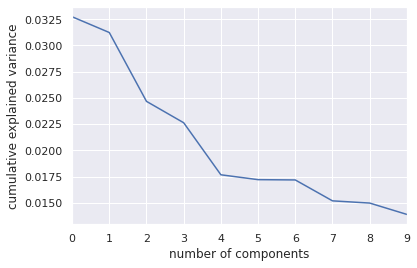

In [378]:
# Воспользуемся методом локтя, чтобы вычислить оптимальное число компонент

plt.plot(TSVD.explained_variance_ratio_)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.xlim((0, 9))
plt.show()

In [379]:
# Снова создадим модель TSVD уже с найденным количеством компонент и обучим нашу матрицу

TSVD = TruncatedSVD(n_components=5, random_state=RANDOM_SEED)

TSVD.fit(tfidf_array)

TruncatedSVD(algorithm='randomized', n_components=5, n_iter=5, random_state=42,
             tol=0.0)

In [380]:
TSVD.explained_variance_ratio_

array([0.0327364 , 0.03123413, 0.02467955, 0.02263131, 0.01766498])

In [381]:
# Уменьшаем размерность нашей tf-idf матрицы до 5 столбцов

TSVD_features = TSVD.transform(tfidf_array)

In [382]:
TSVD_df = pd.DataFrame(TSVD_features, columns = ['TSVD_1', 'TSVD_2', 'TSVD_3', 'TSVD_4', 'TSVD_5'])

In [383]:
df = pd.concat([df, TSVD_df], axis=1)

In [384]:
# Добавим новые признаки в списки

num_cols.extend(['Days_between_reviews', 'Days_Since_Last_Review', 'word_count', 'char_count', 'avg_word_length', 'TSVD_1', 'TSVD_2', 'TSVD_3', 'TSVD_4', 'TSVD_5', 'neg',	'neu',	'pos',	'compound'])

## 8. ID_TA

In [385]:
col_info(df.ID_TA)

Количество пропусков: 0

count       50000
unique      49963
top       d697406
freq            2
Name: ID_TA, dtype: object

Распределение:
d697406     2
d7342803    2
d3161682    2
d2010743    2
d3748757    2
           ..
d8320224    1
d718583     1
d2012797    1
d9803694    1
d8341119    1
Name: ID_TA, Length: 49963, dtype: int64



49963 уникальных значений, даже если есть повторения, многого нам этот признак не даст, удалим его с остальными

# Сохранение датасета после EDA

In [386]:
df.sample(3)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,train,Number_of_Reviews_NAN,Cuisine_Style_NAN,Price_Range_NAN,Country,Population,Restaurants_Count,Restaurants_per_1000,Cuisine_Style_Quantity,is_Top3_Cusine,Cuisines_more_than_median,CuisinesCount_in_City,Weighted_Cuisines_Count,Restaurants_per_Cuisine,Weighted_Ranking,Days_between_reviews,Days_Since_Last_Review,Text_Reviews,neg,neu,pos,compound,word_count,char_count,avg_word_length,TSVD_1,TSVD_2,TSVD_3,TSVD_4,TSVD_5
44342,id_4342,Athens,"[Mediterranean, Greek, Grill, Vegetarian Frien...",1653.0,0.0,0,12.0,"[[Simple, brilliant food with great customer.....",/Restaurant_Review-g189400-d7806427-Reviews-En...,d7806427,0,0.0,0.0,0.0,Greece,664046,776,1.168594,4,1,1,64,0.062500,12.125000,2.130155,76,1633,"[simple, brilliant, food, great, customer, goo...",0.0,0.393,0.607,0.8957,10,53,5.300000,0.320633,-0.002003,-0.128662,0.025185,-0.072746
30827,id_3156,Barcelona,"[Cafe, Spanish, Street Food]",3157.0,4.0,0,15.0,"[[Right for Coffee or even Breakfast, Authenti...",/Restaurant_Review-g187497-d10429136-Reviews-P...,d10429136,1,0.0,0.0,0.0,Spain,1621537,3395,2.093693,3,0,0,96,0.031250,35.364583,0.929897,99,987,"[coffee, even, breakfast, authentic, breakfast...",0.0,1.000,0.000,0.0000,7,51,7.285714,0.049444,0.023792,0.033240,-0.023346,0.046806
6570,id_1960,London,"[Mediterranean, Spanish, Wine Bar, Vegetarian ...",1964.0,4.0,1,225.0,"[[Boutique tapas in Soho-Mayfair, DELICIOUS FO...",/Restaurant_Review-g186338-d2587100-Reviews-Co...,d2587100,1,0.0,0.0,0.0,UK,7556900,7193,0.951845,4,1,1,111,0.036036,64.801802,0.273043,32,831,"[tapas, delicious, food, great, service]",0.0,0.435,0.565,0.8316,8,49,6.125000,0.424709,0.229130,-0.226458,0.144648,-0.062846


In [387]:
cols_to_drop = ['Cuisine Style', 'Restaurant_id', 'Reviews', 'URL_TA', 'Text_Reviews', 'ID_TA']
                
for col in cols_to_drop:
    if col in list(df.columns):
        df.drop(columns=col, inplace=True)

In [388]:
# Проверяем

df.sample(3)

,City,Ranking,Rating,Price Range,Number of Reviews,train,Number_of_Reviews_NAN,Cuisine_Style_NAN,Price_Range_NAN,Country,Population,Restaurants_Count,Restaurants_per_1000,Cuisine_Style_Quantity,is_Top3_Cusine,Cuisines_more_than_median,CuisinesCount_in_City,Weighted_Cuisines_Count,Restaurants_per_Cuisine,Weighted_Ranking,Days_between_reviews,Days_Since_Last_Review,neg,neu,pos,compound,word_count,char_count,avg_word_length,TSVD_1,TSVD_2,TSVD_3,TSVD_4,TSVD_5
49636,Paris,5576.0,0.0,0,184.0,0,0.0,0.0,0.0,France,2138551,6108,2.856140,4,1,1,103,0.038835,59.300971,0.912901,46,837,0.451,0.549,0.0,-0.6249,6,35,5.833333,0.073238,0.017166,0.053537,0.001804,0.192295
47734,Barcelona,5224.0,0.0,1,5.0,0,0.0,1.0,1.0,Spain,1621537,3395,2.093693,3,0,0,96,0.031250,35.364583,1.538733,0,7358,0.000,0.000,0.0,0.0000,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2206,Prague,4043.0,2.5,0,4.0,1,0.0,0.0,0.0,Czech Republic,1165581,1816,1.558021,1,0,0,83,0.012048,21.879518,2.226322,60,878,0.000,1.000,0.0,0.0000,5,34,6.800000,0.067106,0.023028,0.089222,-0.074922,0.080009


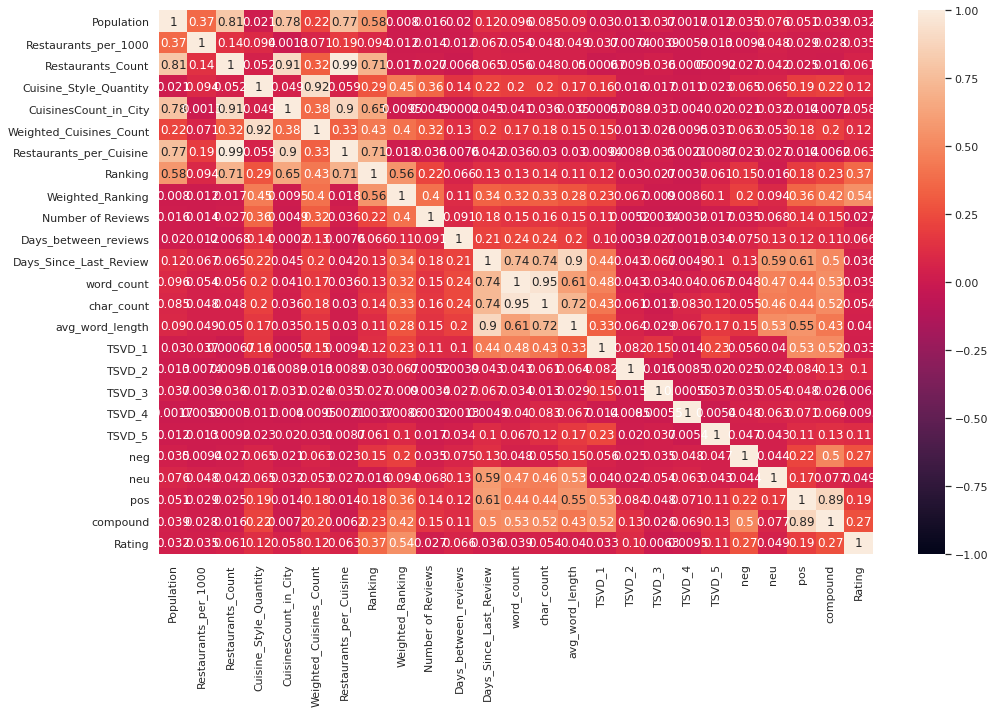

In [389]:
target_cols = ['Rating']

plt.figure(figsize=(16,10))
sns.heatmap(df[df.train==1][num_cols+target_cols].corr().abs(), vmin=-1, vmax=1, annot=True)
plt.show()

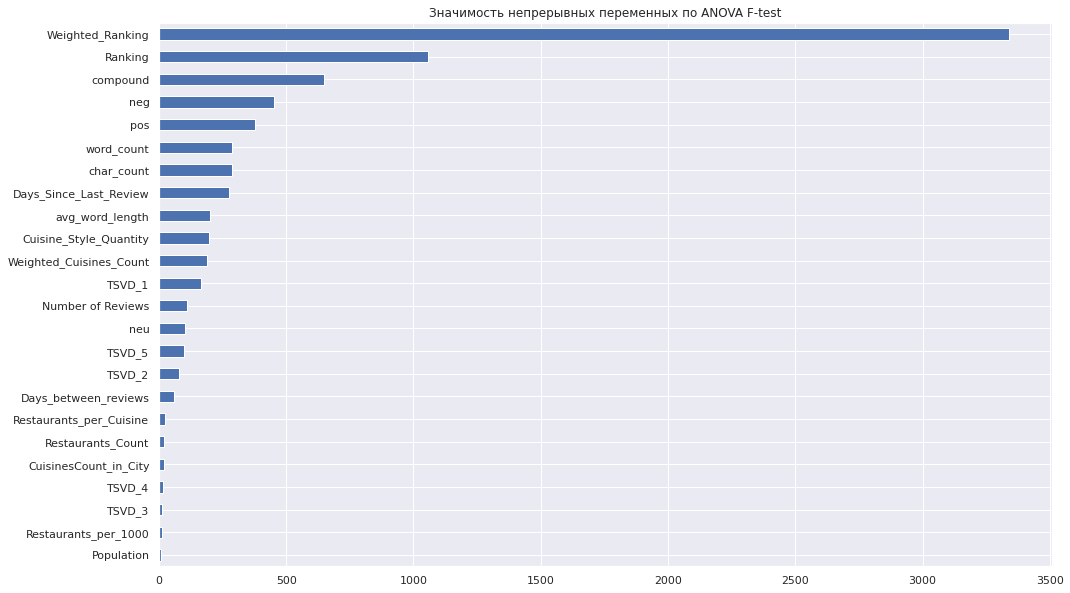

In [390]:
plt.figure(figsize=(16,10))

imp_num = pd.Series(f_classif(df[df.train==1][num_cols], df[df.train==1]['Rating'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh', title='Значимость непрерывных переменных по ANOVA F-test')

plt.show()

In [391]:
# Удалим признаки Population и word_count из нашего датасета

num_cols.remove('word_count')
num_cols.remove('Population')
num_cols.remove('Restaurants_Count')
num_cols.remove('Cuisine_Style_Quantity')

In [392]:
cols_to_drop = ['word_count', 'Population', 'Restaurants_Count', 'Cuisine_Style_Quantity']
                
for col in cols_to_drop:
    if col in list(df.columns):
        df.drop(columns=col, inplace=True)

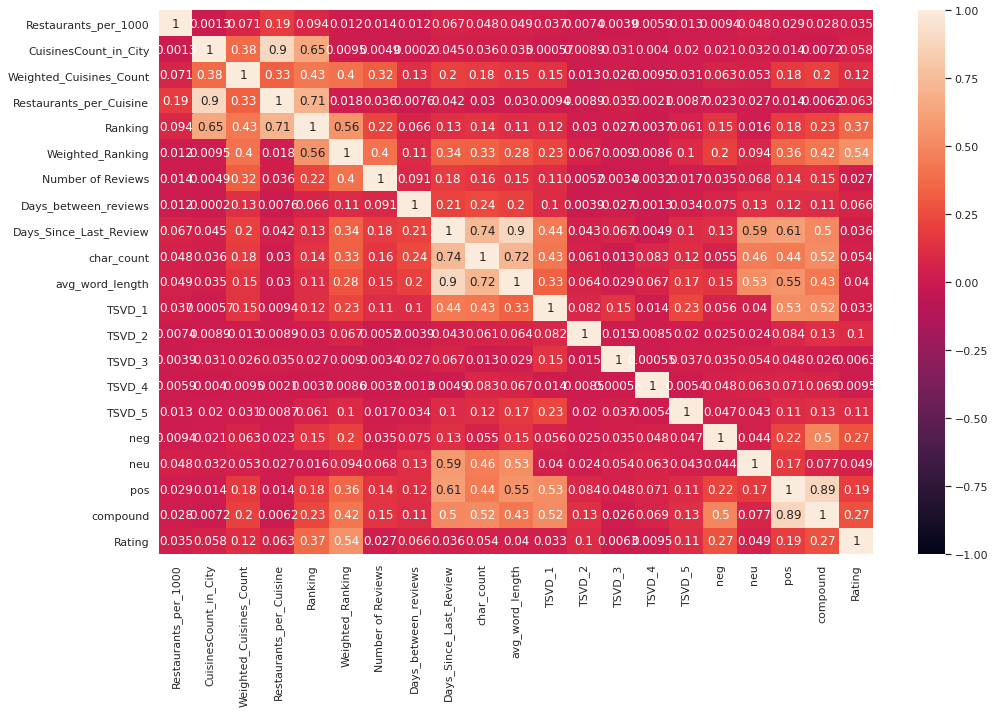

In [393]:
plt.figure(figsize=(16,10))
sns.heatmap(df[df.train==1][num_cols+target_cols].corr().abs(), vmin=-1, vmax=1, annot=True)
plt.show()

In [394]:
df.sample(3)

,City,Ranking,Rating,Price Range,Number of Reviews,train,Number_of_Reviews_NAN,Cuisine_Style_NAN,Price_Range_NAN,Country,Restaurants_per_1000,is_Top3_Cusine,Cuisines_more_than_median,CuisinesCount_in_City,Weighted_Cuisines_Count,Restaurants_per_Cuisine,Weighted_Ranking,Days_between_reviews,Days_Since_Last_Review,neg,neu,pos,compound,char_count,avg_word_length,TSVD_1,TSVD_2,TSVD_3,TSVD_4,TSVD_5
14976,Vienna,1653.0,4.0,1,23.0,1,0.0,1.0,1.0,Austria,0.853105,0,0,90,0.033333,16.033333,1.145530,412,935,0.0,0.435,0.565,0.5994,23,5.750000,0.060392,0.020637,0.072195,-0.045726,0.066395
24120,Amsterdam,1.0,5.0,1,136.0,1,0.0,0.0,0.0,Netherlands,1.849964,1,0,86,0.034884,15.953488,0.000729,2,812,0.0,0.288,0.712,0.7506,34,5.666667,0.015403,0.004979,0.003413,0.006127,0.005940
8764,Paris,10869.0,4.0,1,2.0,1,0.0,1.0,1.0,France,2.856140,0,0,103,0.029126,59.300971,1.779470,0,7358,0.0,0.000,0.000,0.0000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [395]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 30 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   City                       50000 non-null  object 
 1   Ranking                    50000 non-null  float64
 2   Rating                     50000 non-null  float64
 3   Price Range                50000 non-null  int64  
 4   Number of Reviews          50000 non-null  float64
 5   train                      50000 non-null  int64  
 6   Number_of_Reviews_NAN      50000 non-null  float64
 7   Cuisine_Style_NAN          50000 non-null  float64
 8   Price_Range_NAN            50000 non-null  float64
 9   Country                    50000 non-null  object 
 10  Restaurants_per_1000       50000 non-null  float64
 11  is_Top3_Cusine             50000 non-null  int64  
 12  Cuisines_more_than_median  50000 non-null  int64  
 13  CuisinesCount_in_City      50000 non-null  int

In [396]:
# Стандартизируем наши числовые признаки

scaler = StandardScaler()
scaler.fit(df[df.train==1][num_cols])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [397]:
df[num_cols] = scaler.transform(df[num_cols])

In [398]:
# Закодируем наши категориальные переменные при помощи dummy

df = pd.get_dummies(df, columns=cat_cols)

In [399]:
# Добавим сюда наши дамми с кухнями в двух вариантах, первый это все кухни и второй где топ 50

df_1 = pd.concat([df, cuisines_dummy], axis=1)
df_2 = pd.concat([df, cuisines_dummy_50], axis=1)

# Подготовка к машинному обучению

In [400]:
# Выделим трейн и тест у обоих датасетов

# Первый
train_1 = df_1.query('train == 1')
test_1 = df_1.query('train == 0')

train_1.drop(columns=['train'], inplace=True)
test_1.drop(columns=['train'], inplace=True)

# Второй
train_2 = df_2.query('train == 1')
test_2 = df_2.query('train == 0')

train_2.drop(columns=['train'], inplace=True)
test_2.drop(columns=['train'], inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Первый датасет

In [401]:
X = train_1.drop(['Rating'], axis=1)
y = train_1.Rating.values

In [402]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

In [403]:
# проверяем

X.shape, y.shape, X_train.shape, X_test.shape, y_train.shape, y_test.shape

((40000, 206), (40000,), (32000, 206), (8000, 206), (32000,), (8000,))

In [404]:
test_model_1 = RandomForestRegressor(random_state=RANDOM_SEED)
test_model_1.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [405]:
rf_train_pred_1 = test_model_1.predict(X_train)
rf_pred_1 = test_model_1.predict(X_test)

In [406]:
rf_pred_1

array([4.33 , 4.795, 4.29 , ..., 4.615, 4.14 , 4.06 ])

In [407]:
# Реальные рейтинги на сайте всегда кратны 0.5. Следовательно следует ввести корректировки

def real_rating(x, base = 0.5):
    return base * round(x/base)

for i in range(len(rf_train_pred_1)):
    rf_train_pred_1[i] = real_rating(rf_train_pred_1[i])

for i in range(len(rf_pred_1)):
    rf_pred_1[i] = real_rating(rf_pred_1[i])

In [408]:
rf_pred_1

array([4.5, 5. , 4.5, ..., 4.5, 4. , 4. ])

In [409]:
print(f"Точность модели Random Forest 1 по метрике MAE на трейне: {(mean_absolute_error(y_train, rf_train_pred_1)):0.5f}%")
print(f"Точность модели Random Forest 1 по метрике MAE на тесте: {(mean_absolute_error(y_test, rf_pred_1)):0.5f}%")

Точность модели Random Forest 1 по метрике MAE на трейне: 0.01588%
Точность модели Random Forest 1 по метрике MAE на тесте: 0.16887%


Второй датасет

In [410]:
X = train_2.drop(['Rating'], axis=1)
y = train_2.Rating.values

In [411]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

In [412]:
test_model_2 = RandomForestRegressor(random_state=RANDOM_SEED)
test_model_2.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [413]:
rf_train_pred_2 = test_model_2.predict(X_train)
rf_pred_2 = test_model_2.predict(X_test)

In [414]:
for i in range(len(rf_train_pred_2)):
    rf_train_pred_2[i] = real_rating(rf_train_pred_2[i])

for i in range(len(rf_pred_2)):
    rf_pred_2[i] = real_rating(rf_pred_2[i])

In [415]:
print(f"Точность модели Random Forest 1 по метрике MAE на трейне: {(mean_absolute_error(y_train, rf_train_pred_2)):0.5f}%")
print(f"Точность модели Random Forest 1 по метрике MAE на тесте: {(mean_absolute_error(y_test, rf_pred_2)):0.5f}%")

Точность модели Random Forest 1 по метрике MAE на трейне: 0.01575%
Точность модели Random Forest 1 по метрике MAE на тесте: 0.16912%


По итогу первый датасет оказался лучше, будем использовать его

# Machine Learning

In [416]:
# Еще раз продублируем создание трейна и теста

X = train_1.drop(['Rating'], axis=1)
y = train_1.Rating.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

## LightGBM

In [417]:
lgbm = lgb.LGBMRegressor(n_estimators=1000, random_state=RANDOM_SEED)
lgbm.fit(X_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=1000, n_jobs=-1, num_leaves=31, objective=None,
              random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [418]:
lgbm_train_pred = lgbm.predict(X_train)
lgbm_pred = lgbm.predict(X_test)

In [419]:
lgbm_train_pred = lgbm.predict(X_train)
lgbm_pred = lgbm.predict(X_test)

for i in range(len(lgbm_train_pred)):
    lgbm_train_pred[i] = real_rating(lgbm_train_pred[i])

for i in range(len(lgbm_pred)):
    lgbm_pred[i] = real_rating(lgbm_pred[i])

In [420]:
print(f"Точность модели LightGBM по метрике MAE на трейне: {(mean_absolute_error(y_train, lgbm_train_pred)):0.5f}%")
print(f"Точность модели LightGBM по метрике MAE на тесте: {(mean_absolute_error(y_test, lgbm_pred)):0.5f}%")

Точность модели LightGBM по метрике MAE на трейне: 0.05995%
Точность модели LightGBM по метрике MAE на тесте: 0.16394%


## ExtraTreesRegressor

In [421]:
etr = ExtraTreesRegressor(bootstrap=True, random_state=RANDOM_SEED)
etr.fit(X_train, y_train)

ExtraTreesRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=None, oob_score=False,
                    random_state=42, verbose=0, warm_start=False)

In [422]:
etr_train_pred = etr.predict(X_train)
etr_pred = etr.predict(X_test)

for i in range(len(etr_train_pred)):
    etr_train_pred[i] = real_rating(etr_train_pred[i])

for i in range(len(etr_pred)):
    etr_pred[i] = real_rating(etr_pred[i])

In [423]:
print(f"Точность модели ExtraTreesRegressor по метрике MAE на трейне: {(mean_absolute_error(y_train, etr_train_pred)):0.5f}%")
print(f"Точность модели ExtraTreesRegressor по метрике MAE на тесте: {(mean_absolute_error(y_test, etr_pred)):0.5f}%")

Точность модели ExtraTreesRegressor по метрике MAE на трейне: 0.01539%
Точность модели ExtraTreesRegressor по метрике MAE на тесте: 0.17413%


In [424]:
rf_pred_1_ = test_model_1.predict(X_test)
lgbm_pred_ = lgbm.predict(X_test)

In [425]:
# Найдем среднее среди предсказаний случайного леса и лгбм с коэффициентами соответственно 0.4, 0.6 (лучший результат)

pred_df = pd.DataFrame({'random_forest':rf_pred_1_, 'light_gbm': lgbm_pred_, 'Rating' : y_test})
pred_df

,random_forest,light_gbm,Rating
0,4.330,4.474820,5.0
1,4.795,4.767883,5.0
2,4.290,4.089570,4.0
3,3.465,3.370559,3.5
4,3.960,3.893589,3.5
...,...,...,...
7995,4.985,4.888054,5.0
7996,2.700,2.637828,2.5
7997,4.615,4.695779,4.5
7998,4.140,4.122782,4.0


In [426]:
final_pred = rf_pred_1_*0.4 + lgbm_pred_*0.6
for i in range(len(final_pred)):
    final_pred[i] = real_rating(final_pred[i])

print(f"Точность по метрике MAE после усреднения предсказаний: {(mean_absolute_error(y_test, final_pred)):0.5f}%")

Точность по метрике MAE после усреднения предсказаний: 0.16012%


По итогу усреднение результатов модели с распределением коэффициентов в зависимости от точности модели дало лучший результат по метрике. Приступим к подбору параметров для моделей

# Подбор гиперпараметров и построение финальной модели

In [427]:
### Random Forest ###
#
#rf_grid = {'n_estimators' : [int(x) for x in np.linspace(start = 100, stop = 500, num = 9)],
#           'max_features' : ['auto', 'sqrt', 'log2'],
#           'max_depth' : [3, 5, 7, 10, 15, None],
#           'min_samples_split' : [2, 4, 6]  
#           }
#
#rf = RandomForestRegressor(random_state=RANDOM_SEED)
#rf_randcv = RandomizedSearchCV(estimator = rf, 
#                                param_distributions = rf_grid, 
#                                n_iter = 30, 
#                                cv = 3, 
#                                verbose=2, 
#                                random_state=RANDOM_SEED)
#rf_randcv.fit(X_train, y_train)

In [428]:
rf = RandomForestRegressor(min_samples_split=6, random_state=RANDOM_SEED)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=6, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [429]:
rf_train_pred = rf.predict(X_train)
rf_pred = rf.predict(X_test)

for i in range(len(rf_train_pred)):
    rf_train_pred[i] = real_rating(rf_train_pred[i])

for i in range(len(rf_pred)):
    rf_pred[i] = real_rating(rf_pred[i])

In [430]:
print(f"Точность модели Random Forest по метрике MAE на трейне: {(mean_absolute_error(y_train, rf_train_pred)):0.5f}%")
print(f"Точность модели Random Forest по метрике MAE на тесте: {(mean_absolute_error(y_test, rf_pred)):0.5f}%")

Точность модели Random Forest по метрике MAE на трейне: 0.03037%
Точность модели Random Forest по метрике MAE на тесте: 0.16781%


In [482]:
#lgbm_grid = {
#    'n_estimators' : [int(x) for x in np.linspace(start = 100, stop = 1500, num = 15)],
#    'num_leaves': list(range(20, 150)),
#    'learning_rate': list(np.logspace(np.log10(0.005), np.log10(0.5), base = 10, num = 1000)),
#    'min_data_in_leaf' : list(range(20, 200, 5)),
#    'min_child_samples': list(range(20, 500, 5)),
#    'max_depth' : [-1, 5, 7, 10, 15, 25],
#    'reg_alpha': list(np.linspace(0, 1)),
#    'reg_lambda': list(np.linspace(0, 1))
#}
#
#lgbm = lgb.LGBMRegressor(random_state=RANDOM_SEED)
#lgbm_randcv = RandomizedSearchCV(estimator = lgbm, 
#                                param_distributions = lgbm_grid, 
#                                n_iter = 100, 
#                                cv = 3,
#                                scoring='neg_mean_absolute_error',  
#                                verbose=2, 
#                                random_state=RANDOM_SEED)
#lgbm_randcv.fit(X_train, y_train)

In [487]:
lgbm = lgb.LGBMRegressor(n_estimators=600, learning_rate=0.0192112042302753, min_child_samples=120, min_data_in_leaf=55, num_leaves=81, random_state=RANDOM_SEED, reg_alpha=0.8775510204081632, reg_lambda=0.673469387755102)
lgbm.fit(X_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.0192112042302753,
              max_depth=-1, min_child_samples=120, min_child_weight=0.001,
              min_data_in_leaf=55, min_split_gain=0.0, n_estimators=600,
              n_jobs=-1, num_leaves=81, objective=None, random_state=42,
              reg_alpha=0.8775510204081632, reg_lambda=0.673469387755102,
              silent=True, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)

In [488]:
lgbm_train_pred = lgbm.predict(X_train)
lgbm_pred = lgbm.predict(X_test)

In [489]:
lgbm_train_pred = lgbm.predict(X_train)
lgbm_pred = lgbm.predict(X_test)

for i in range(len(lgbm_train_pred)):
    lgbm_train_pred[i] = real_rating(lgbm_train_pred[i])

for i in range(len(lgbm_pred)):
    lgbm_pred[i] = real_rating(lgbm_pred[i])

In [490]:
print(f"Точность модели LightGBM по метрике MAE на трейне: {(mean_absolute_error(y_train, lgbm_train_pred)):0.5f}%")
print(f"Точность модели LightGBM по метрике MAE на тесте: {(mean_absolute_error(y_test, lgbm_pred)):0.5f}%")

Точность модели LightGBM по метрике MAE на трейне: 0.12381%
Точность модели LightGBM по метрике MAE на тесте: 0.16175%


In [491]:
rf_opt_pred_ = rf.predict(X_test)
lgbm_opt_pred_ = lgbm.predict(X_test)

In [502]:
# Найдем среднее среди предсказаний случайного леса и лгбм с коэффициентами соответственно 0.2, 0.8 (лучший результат)

pred_df = pd.DataFrame({'random_forest':rf_opt_pred_, 'light_gbm': lgbm_opt_pred_, 'Rating' : y_test})
pred_df

,random_forest,light_gbm,Rating
0,4.337048,4.463733,5.0
1,4.681411,4.785610,5.0
2,4.238720,4.166812,4.0
3,3.480897,3.367549,3.5
4,3.932611,3.948027,3.5
...,...,...,...
7995,4.985698,5.039682,5.0
7996,2.746804,2.713413,2.5
7997,4.592083,4.739919,4.5
7998,4.137917,4.128766,4.0


In [503]:
final_pred_ = rf_opt_pred_*0.2 + lgbm_opt_pred_*0.8
for i in range(len(final_pred_)):
    final_pred_[i] = real_rating(final_pred_[i])

print(f"Точность по метрике MAE после усреднения предсказаний: {(mean_absolute_error(y_test, final_pred_)):0.5f}%")

Точность по метрике MAE после усреднения предсказаний: 0.16012%


## Финальная модель

In [507]:
X_train = train_1.drop(['Rating'], axis=1)
y_train = train_1.Rating
X_test = test_1.drop(['Rating'], axis=1)

In [511]:
rf = RandomForestRegressor(min_samples_split=6, random_state=RANDOM_SEED)
rf.fit(X_train, y_train)
rff_pred = rf.predict(X_test)

In [512]:
lgbm = lgb.LGBMRegressor(n_estimators=600, learning_rate=0.0192112042302753, min_child_samples=120, min_data_in_leaf=55, num_leaves=81, random_state=RANDOM_SEED, reg_alpha=0.8775510204081632, reg_lambda=0.673469387755102)
lgbm.fit(X_train, y_train)
lgbmf_pred = lgbm.predict(X_test)

In [513]:
final = rff_pred*0.2 + lgbmf_pred*0.8
for i in range(len(final)):
    final[i] = real_rating(final[i])

In [516]:
sample_submission['Rating'] = final
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.5
1,id_1,4.0
2,id_2,4.5
3,id_3,4.5
4,id_4,4.5
5,id_5,4.5
6,id_6,3.0
7,id_7,2.5
8,id_8,4.0
9,id_9,4.5
